# 02 - Latent Semantic Analysis (LSA)
This notebook performs Latent Semantic Analysis on the governance data set. It assumes the data was cleaned and placed in the cache by the "Explore the Governance Data Set" notebook.

We start out by replicating the steps that Joshua Cook shows in his [Introduction to Latent Semantic Analysis](https://www.youtube.com/playlist?list=PLroeQp1c-t3qwyrsq66tBxfR6iX6kSslt) youtube series. Although we follow his examples, we renamed a few things, graphed some of it and wrap results in a Pandas data frame for readability and easy handling. From there we apply the same to out governance data set. It starts off pretty similar to our earlier notebook that performs a TF-IDF analysis of the documents.

---
## Dependencies and Imports
Here we import the libraries we need to perform our analysis.

In [98]:
!pip install scikit-learn pandas seaborn graphviz

In [99]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import seaborn as sns
CMAP_VLAG = sns.color_palette("vlag", as_cmap=True)
print(f"seaborn=={sns.__version__}")

from graphviz import __version__ as graphviz__version__
print(f"graphviz=={graphviz__version__}")
from graphviz import Source as dot_graph


python==3.10.9
scikit-learn==1.2.2
pandas==2.0.1
matplotlib==3.7.1
seaborn==0.12.2
graphviz==0.20.1


---
## Replicate Joshua Cook's Examples
Joshua starts with a trivial set of documents, represented here by a simple array of strings.


In [100]:
trivial_corpus = [
    "the quick brown fox",
    "the slow brown dog",
    "the quick red dog",
    "the lazy yellow fox"
]


### Document-Term Matrix
Using a count vectorizer he calculates what he calls the document-term matrix. He also uses the term "bag of words", but in this notebook we use the name document-term matrix for precision.

We won't use it on the trivial corpus, but I added the `min_df` parameter for use with the governance data set, later on. That parameter helped a lot to get better results and I expect we will use it again.

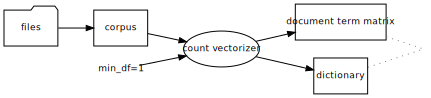

In [101]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=folder]; files;
  node [shape=oval]; vec [label="count vectorizer"];
  node [shape=plain]; min_df [label="min_df=1"]; dot0 [label=" "];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"];

  files -> corpus;
  min_df -> vec;
  corpus -> vec;
  vec -> dtm;
  vec -> dict;
  dtm -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
  dict -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
}
''')

In [102]:
def make_document_term_matrix(corpus, min_df=1):
    count_vectorizer = CountVectorizer(min_df=min_df)
    count_matrix     = count_vectorizer.fit_transform(corpus)
    count_word_list  = count_vectorizer.get_feature_names_out()

    return pd.DataFrame(index=corpus, columns=count_word_list, data=count_matrix.toarray()), \
           count_vectorizer.get_feature_names_out()

trivial_document_term_matrix, trivial_dictionary = make_document_term_matrix(trivial_corpus)
trivial_document_term_matrix

,brown,dog,fox,lazy,quick,red,slow,the,yellow
the quick brown fox,1,0,1,0,1,0,0,1,0
the slow brown dog,1,1,0,0,0,0,1,1,0
the quick red dog,0,1,0,0,1,1,0,1,0
the lazy yellow fox,0,0,1,1,0,0,0,1,1


### Singular Value Decomposition (SVD)
Singular value decomposition (SVD) encodes our corpus into topic encoded data. Instead of feeding it our text corpus, SVD relies on the document-term matrix produced by the count vectorizer above. We use the text corpus only as index so the resulting Pandas data frame is readable. The algorithm relies on the document-term matrix alone.

To make it easier to determine what a topic is about, the LSA function below also returns a encoding matrix based on the dictionary from the count vectorizer.

Using the same, trivial corpus nicely shows a distinction between the documents talking about dogs (shown as "topic 0") and foxes (as "topic 1").


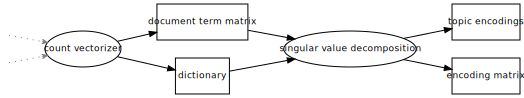

In [103]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=plain label=" "]; dot0; dot1;
  node [shape=oval]; vec [label="count vectorizer"]; svd [label="singular value decomposition"];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"]; topic_enc [label="topic encodings"];
    enc_mtx [label="encoding matrix"];

  dot0 -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  dot1 -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  vec -> dtm;
  vec -> dict;
  dtm -> svd;
  dict -> svd;
  svd -> topic_enc;
  svd -> enc_mtx;
}
''')

In [104]:
def lsa_of(corpus, dictionary, document_term_matrix, n_components=2):
    svd = TruncatedSVD(n_components=n_components)
    lsa = svd.fit_transform(document_term_matrix)
    topics = [f"topic {n}" for n in range(lsa.shape[1])]
    return pd.DataFrame(index=corpus, data=lsa, columns=topics), \
           pd.DataFrame(index=topics, data=svd.components_, columns=dictionary).T

trivial_topic_encodings, trivial_encoding_matrix = lsa_of(trivial_corpus, trivial_dictionary, trivial_document_term_matrix)
trivial_topic_encodings


,topic 0,topic 1
the quick brown fox,1.694905,0.299524
the slow brown dog,1.515851,-0.769110
the quick red dog,1.515851,-0.769110
the lazy yellow fox,1.266186,1.440585


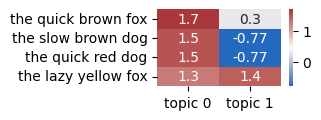

In [105]:
plt.figure(figsize=(2, 1))
sns.heatmap(trivial_topic_encodings, annot=True, cmap=CMAP_VLAG);


In [106]:
trivial_encoding_matrix


,topic 0,topic 1
brown,0.353937,-0.140256
dog,0.334199,-0.459436
fox,0.326416,0.519736
lazy,0.139578,0.430274
quick,0.353937,-0.140256
red,0.167100,-0.229718
slow,0.167100,-0.229718
the,0.660615,0.060300
yellow,0.139578,0.430274


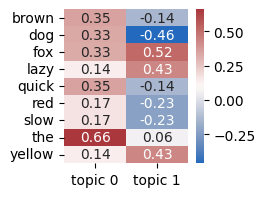

In [107]:
plt.figure(figsize=(2, 2))
sns.heatmap(trivial_encoding_matrix, annot=True, cmap=CMAP_VLAG);


In his code, Joshua takes the absolute values of the topic columns. In his presentation he suggests that we should be looking for the strongest correlations, either negative or positive. Instead of adding columns, we take the absolute value on the fly as we search for the $n$ most significant terms. We don't preserve the absolute values, since they are not needed after selection.

Based on the heatmap above, "topic 1" seems to be based around the type of animal. It has a strong correlation with "fox" and a strong negative correlation with "dog". This is further supported by selecting the most significant terms as shown below.

The stop words are still present. We don't worry about them as they will have been stripped in the data cleaning process of the governance data set.

In [108]:
def n_most_significant(topic, n_terms, encoding_matrix):
    df = encoding_matrix[topic]
    return df.iloc[df.abs().argsort()][::-1][:n_terms].to_frame()

In [109]:
n_most_significant("topic 0", 3, trivial_encoding_matrix)

,topic 0
the,0.660615
quick,0.353937
brown,0.353937


In [110]:
n_most_significant("topic 1", 2, trivial_encoding_matrix)

,topic 1
fox,0.519736
dog,-0.459436


**node**: The scatter plot that Joshua makes relies on the user-supplied classification of the documents. This is an example of supervised input as part of the data validation. Our product owner also spoke of this. We can start doing that once we are working with the whole corpus and have the document type at hand.

XXX: make this plot...

---
## Apply LSA to the Governance Data Set
When we apply LSA to the governance data set we bring in the document class as a separate column. We don't use this during analysis, but it allows us to colour the graphs based on the document type, to validate the analysis.

### Load the Governance Data

In [113]:
CACHE_DIR = '../cache/Governance'

# The files containing the extracted text from the raw documents.
GLOB_ALL_DOCUMENTS = CACHE_DIR + '/GM????????.txt'

GLOB_CA = CACHE_DIR + '/GM????CA??.txt'
GLOB_DV = CACHE_DIR + '/GM????DV??.txt'
GLOB_EX = CACHE_DIR + '/GM????EX??.txt'
GLOB_IK = CACHE_DIR + '/GM????IK??.txt'
GLOB_JS = CACHE_DIR + '/GM????JS??.txt'
GLOB_OB = CACHE_DIR + '/GM????OB??.txt'
GLOB_PB = CACHE_DIR + '/GM????PB??.txt'
GLOB_TV = CACHE_DIR + '/GM????TV??.txt'
GLOB_WS = CACHE_DIR + '/GM????WS??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"all text documents = {GLOB_ALL_DOCUMENTS}")

DOCUMENT_TYPE = 'document type'
DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_TYPE] = [file.stem[6:8]   for file in expand_glob(glob)]

    df[DOCUMENT_TYPE] = df[DOCUMENT_TYPE].astype(CATEGORY)
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


all text documents = ../cache/Governance/GM????????.txt


In [114]:
corpus = load_corpus_as_dataframe(GLOB_ALL_DOCUMENTS)
corpus


,body,document type
GM0003DV02,duurzaamheidsbeleid appingedam duurzaamheidsbe...,DV
GM0003EX06,bedrijventerreinenvisie bedrijventerreinenvisi...,EX
GM0003OB01,inkop aanbestedingsbeleid samenwerk gemeent va...,OB
GM0003OB02,evaluatie proefproject welzijn nieuw stijl app...,OB
GM0005CA01,,CA
...,...,...
GM1987DV01,milieu uitvoeringsprogramma milieu uitvoerings...,DV
GM1987IK01,inkop aanbestedingsbeleid gemeent menterwold g...,IK
GM1987JS01,rekenkamercommissie rekenkamercommissie gemeen...,JS
GM1987PB01,begrot programma begrot begrot inleid dames he...,PB


In [115]:
corpus.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2232 entries, GM0003DV02 to GM1987TV01
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   body           2232 non-null   string  
 1   document type  2232 non-null   category
dtypes: category(1), string(1)
memory usage: 37.4+ KB


In [116]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix(series, min_df=1):
    count_vectorizer = CountVectorizer(min_df=min_df)
    count_matrix     = count_vectorizer.fit_transform(series)
    count_word_list  = count_vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=count_word_list, data=count_matrix.toarray()), \
           count_vectorizer.get_feature_names_out()

document_term_matrix, dictionary = compose_document_term_matrix(corpus[DOCUMENT_BODY], 20)
document_term_matrix

,aaa,aach,aal,aalburg,aalsmer,aalt,aanb,aanbest,aanbested,aanbesteder,...,zwemveren,zwemvoorzien,zwemwater,zwerf,zwerfafval,zwerfdier,zwerfvuil,zwijndrecht,zwoll,zzp
GM0003DV02,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
GM0003EX06,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GM0003OB01,0,0,0,0,0,0,0,0,96,0,...,0,0,0,0,0,0,0,0,0,1
GM0003OB02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GM0005CA01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1987DV01,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,1,0,0,0,0,0
GM1987IK01,0,0,0,0,0,0,0,0,94,6,...,0,0,0,0,0,0,0,0,0,0
GM1987JS01,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
GM1987PB01,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
dictionary

array(['aaa', 'aach', 'aal', ..., 'zwijndrecht', 'zwoll', 'zzp'],
      dtype=object)

In [118]:
def perform_lsa(document_term_matrix, dictionary, n_components=2):
    svd = TruncatedSVD(n_components=n_components)
    lsa = svd.fit_transform(document_term_matrix)
    topics = [f"topic {n}" for n in range(lsa.shape[1])]
    return pd.DataFrame(index=document_term_matrix.index, data=lsa, columns=topics), \
           pd.DataFrame(index=topics, data=svd.components_, columns=dictionary).T

topic_encodings, encoding_matrix = perform_lsa(document_term_matrix, dictionary)
topic_encodings


,topic 0,topic 1
GM0003DV02,239.031170,-144.451643
GM0003EX06,209.183313,-122.553994
GM0003OB01,224.548293,-95.381057
GM0003OB02,85.347110,-49.878267
GM0005CA01,0.000000,0.000000
...,...,...
GM1987DV01,241.099397,-127.135140
GM1987IK01,133.793110,-58.180175
GM1987JS01,58.457029,-28.660858
GM1987PB01,791.257716,-77.928755


In [119]:
encoding_matrix

,topic 0,topic 1
aaa,0.000202,-0.000012
aach,0.000137,0.000021
aal,0.000093,-0.000012
aalburg,0.000292,0.000086
aalsmer,0.002513,-0.001668
...,...,...
zwerfdier,0.000165,-0.000089
zwerfvuil,0.000486,-0.000181
zwijndrecht,0.001635,0.001108
zwoll,0.003436,-0.002876


In [120]:
n_most_significant("topic 0", 10, encoding_matrix)

,topic 0
vor,0.471045
eur,0.427458
gemeent,0.312861
word,0.217634
dez,0.165196
dor,0.158557
begrot,0.136028
jar,0.122144
nar,0.105003
programma,0.095862


In [121]:
n_most_significant("topic 1", 10, encoding_matrix)

,topic 1
eur,0.862988
vor,-0.272252
gemeent,-0.150216
word,-0.134923
dor,-0.086808
dez,-0.085994
ontwikkel,-0.073657
mogelijk,-0.068149
duurzam,-0.065669
nar,-0.057670
